In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.tsa.api as sm
from statsmodels.tsa.arima.model import ARIMA

In [3]:
df = pd.read_csv('Israel_Palestine_Public_Opinion_Dataset.csv')

# Table of Contents
1. [Data Preprocessing](#Data-Preprocessing)
   1. [Dropping Irrelevant Features](#Dropping-irrelevant-features)
   2. [Dealing with Missing Values](#Dealing-with-Missing-Values)
   3. [Dealing with Duplicates](#Dealing-with-Duplicates)
   4. [Converting Data Types](#Converting-Data-Types)
   5. [Creating Two Subsets](#Creating-Two-Subsets)
       1. [Comments per Day](#Comments-per-Day)
2. [Augmented Dickey-Fuller Test for Oct. 7](#Augmented-Dickey-Fuller-Test-for-Oct.-7)
   1. [ACF and PACF for Oct. 7](#ACF-and-PACF-for-Oct.-7)
3. [Augmented Dickey-Fuller Test for Daily Data](#Augmented-Dickey-Fuller-Test-for-Daily-Data)
   1. [Making Daily Data Stationary with Differencing](#Making-Daily-Data-Stationary-with-Differencing)
   2. [ACF and PACF for Stationary Daily Data](#ACF-and-PACF-for-Stationary-Daily-Data)
4. [Identifying Best P & Q Values](#Identifying-Best-P-&-Q-values)
   1. [Plotting Twice Differenciated Dataset](#Plotting-Twice-Differenciated-Dataset)
5. [Fitting ARIMA Model](#Fitting-ARIMA-Model)
6. [Forecasting](#Forecasting)
   1. [Visualising the Mismatch](#Visualising-the-Mismatch)
   2. [Forecasting Last 10 Observations](#Forecasting-Last-10-Observations)
   3. [Forecasting Errors](#Forecasting-Errors)
   4. [In-Sample Forecasting](#In-Sample-Forecasting)
7. [Time Series Plot](#Time-Series-Plot)
8. [Sample & Partial Autocorrelation](#Sample-&-Partial-Autocorrelation)
   1. [Sample Autocorrelation (ACF)](#Sample-Autocorrelation-(ACF))
   2. [Partial Autocorrelation (PA)](#Partial-Autocorrelation-(PA))


In [4]:
df.shape

(75543, 6)

In [5]:
df.sample(20)

,comment_id,score,self_text,subreddit,created_time,created_date
25890,k5jutrk,164,The Israeli narrative is that they have to dis...,PublicFreakout,2023-10-19 14:41:33+00:00,2023-10-19
28762,k5rq82n,1,I don't think so. That could happen if there w...,IsraelPalestine,2023-10-21 01:04:48+00:00,2023-10-21
74876,k9nhqo1,6,"Dude, don't bring the ""half the population is ...",worldnews,2023-11-17 16:24:11+00:00,2023-11-17
65359,k8odsgh,11,What if she was wearing a MAGA hat?,PublicFreakout,2023-11-10 18:13:31+00:00,2023-11-10
19696,k545fcq,1,You’re not distinguishing between what you thi...,IsraelPalestine,2023-10-16 13:50:51+00:00,2023-10-16
33123,k65ntmb,1,Too much to lose by fighting. Not enough to be...,worldnews,2023-10-23 20:44:20+00:00,2023-10-23
56433,k7ways8,2,Alright. Lets talk evidence. Stop comparing Pa...,IsraelPalestine,2023-11-05 06:42:59+00:00,2023-11-05
10936,k4q671q,3,"Yea, you are very correct. They are a militia,...",worldnews,2023-10-13 16:38:13+00:00,2023-10-13
43114,k6xfw8g,2,There were a few protesters of few people. The...,IsraelPalestine,2023-10-29 08:19:26+00:00,2023-10-29
7657,k4cqjko,1,To download the video you can use one of the f...,AskMiddleEast,2023-10-11 00:39:20+00:00,2023-10-11


# Data Preprocessing

### Dropping irrelevant features

We begin by removing the columns we don't need for this section.

The score & subreddit features could be kept/added in later if we wanted to go more in depth regarding user engagement (score), or seening trends across subreddits.

In [6]:
df = df.drop(columns = ['comment_id', 'score', 'self_text', 'subreddit'])

In [7]:
df.head()

,created_time,created_date
0,2023-10-07 12:09:52+00:00,2023-10-07
1,2023-10-07 08:53:35+00:00,2023-10-07
2,2023-10-07 16:56:03+00:00,2023-10-07
3,2023-10-07 15:49:09+00:00,2023-10-07
4,2023-10-07 06:51:44+00:00,2023-10-07


In [8]:
df.tail()

,created_time,created_date
75538,2023-11-17 16:35:31+00:00,2023-11-17
75539,2023-11-17 14:53:33+00:00,2023-11-17
75540,2023-11-17 15:36:58+00:00,2023-11-17
75541,2023-11-17 21:43:24+00:00,2023-11-17
75542,2023-11-17 15:49:52+00:00,2023-11-17


### Dealing with Missing Values

In [9]:
missing_values = df.isnull().sum()
print("Missing values in each column:\n", missing_values)

Missing values in each column:
 created_time    0
created_date    0
dtype: int64


### Dealing with Duplicates

In [10]:
duplicates = df.duplicated().sum()
print("Number of duplicate rows:", duplicates)

Number of duplicate rows: 918


In [11]:
df = df.drop_duplicates()

In [12]:
df.shape

(74625, 2)

### Converting Data Types

In [13]:
df.dtypes

created_time    object
created_date    object
dtype: object

In [14]:
df['created_time'] = pd.to_datetime(df['created_time'])
df['created_date'] = pd.to_datetime(df['created_date'])

In [15]:
df.sort_values(by='created_time', inplace=True)

In [16]:
df.dtypes

created_time    datetime64[ns, UTC]
created_date         datetime64[ns]
dtype: object

In [17]:
df.head(10)

,created_time,created_date
1073,2023-10-07 00:25:23+00:00,2023-10-07
1088,2023-10-07 00:59:10+00:00,2023-10-07
13,2023-10-07 04:16:47+00:00,2023-10-07
620,2023-10-07 04:23:35+00:00,2023-10-07
83,2023-10-07 04:39:14+00:00,2023-10-07
634,2023-10-07 04:42:58+00:00,2023-10-07
284,2023-10-07 04:45:30+00:00,2023-10-07
1029,2023-10-07 04:47:50+00:00,2023-10-07
856,2023-10-07 04:55:27+00:00,2023-10-07
283,2023-10-07 05:10:46+00:00,2023-10-07


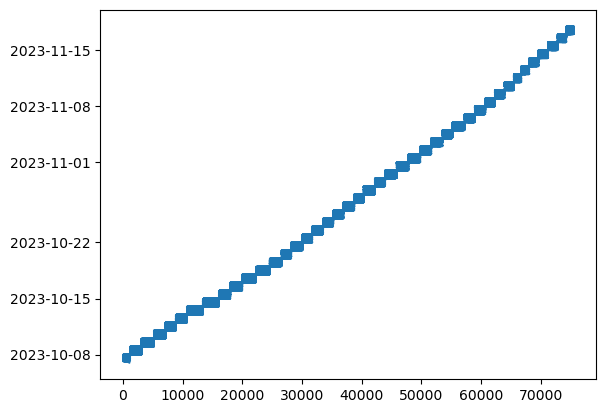

In [18]:
df["created_time"].plot();

## Creating Two Subsets

One subset will be used to analyse the comments per hour on the day of the Hamas attack on Israel (Oct. 7).
The other subset will consist of the aggregate of comments per day, in order to investigate the trends there (peaks/valleys over time

In [19]:
Oct_7 = df[df['created_date'] == pd.to_datetime('2023-10-07')]

Oct_7['hour'] = Oct_7['created_time'].dt.hour

Oct_7_hours = Oct_7.groupby('hour').size()

#### Comments per hour on Oct. 7

<Axes: title={'center': 'Hourly Comment Volume on 2023-10-07'}, xlabel='hour'>

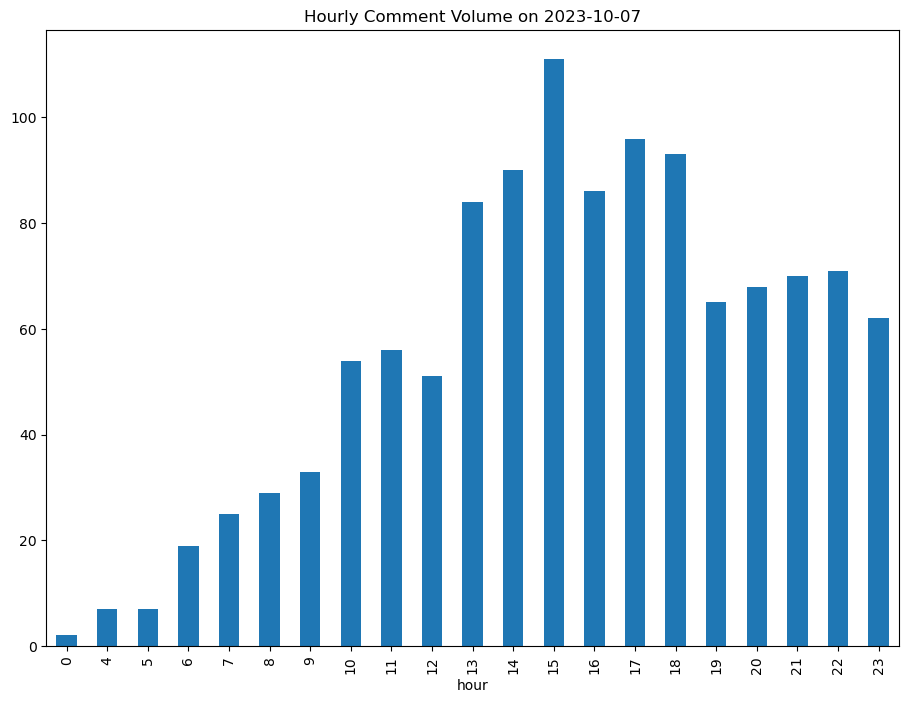

In [20]:
Oct_7_hours.plot(kind='bar', figsize=(11, 8), title='Hourly Comment Volume on 2023-10-07')

In [21]:
daily_data = df.groupby('created_date').size()

#### Comments per Day


<Axes: title={'center': 'Daily Comment Volume'}, xlabel='created_date'>

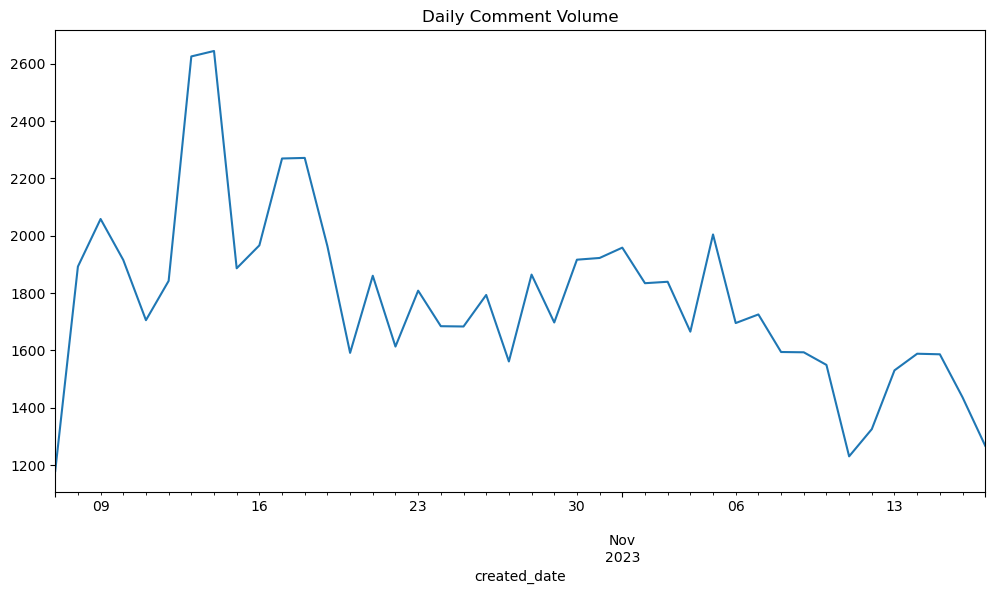

In [22]:
daily_data.plot(kind='line', figsize=(12, 6), title='Daily Comment Volume')

# Augmented Dickey-Fuller Test for Oct. 7

In [23]:
ADF_oct7 = adfuller(Oct_7_hours)
print('ADF Statistic for Oct 7: %f' % ADF_oct7[0])
print('p-value for Oct 7: %f' % ADF_oct7[1])

ADF Statistic for Oct 7: -1.765296
p-value for Oct 7: 0.397822


### ACF and PACF for Oct. 7

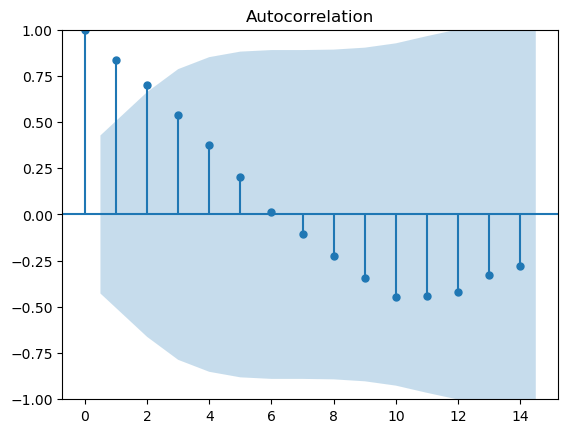

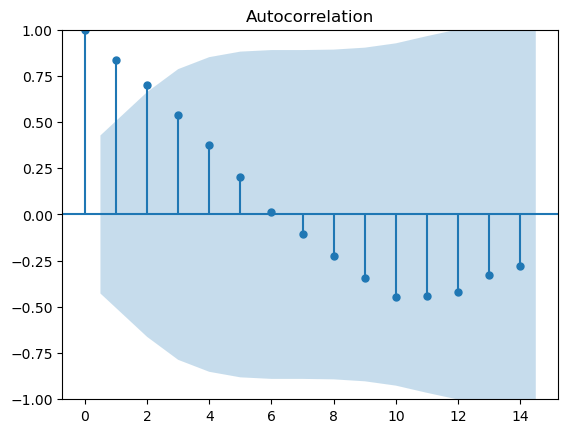

In [24]:
plot_acf(Oct_7_hours)
    # Oct. 12th lecture (Weiss, 2023)

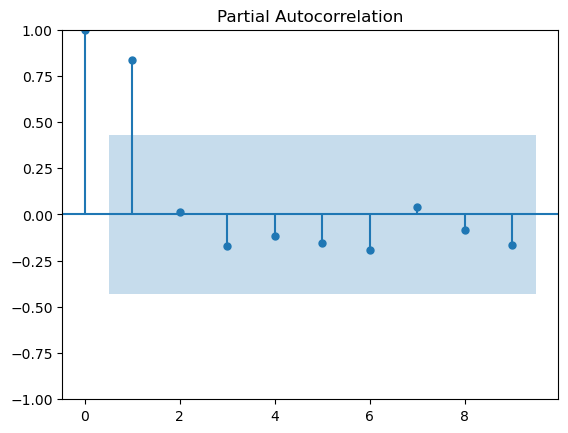

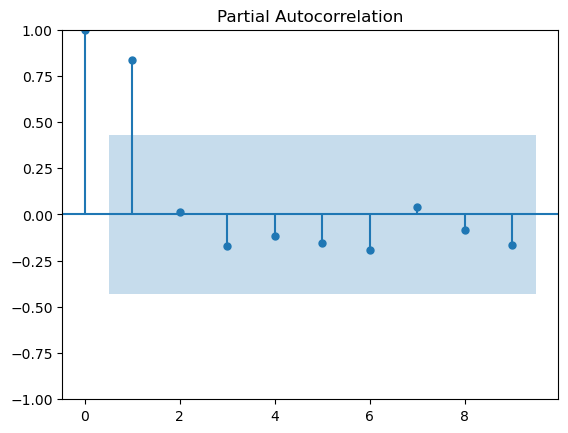

In [25]:
    # plot_pacf(Oct_7_hours, method='ywm')
    # error due to no. lag requested too high
    '''ValueError: Can only compute partial correlations for lags up to 50% of the sample size. 
    The requested nlags 14 must be < 10.
    Solution: set the max lags as half the subset minus one'''
max_lags = len(Oct_7_hours) // 2 - 1  
plot_pacf(Oct_7_hours, lags=max_lags, method='ywm')

# Augmented Dickey-Fuller Test for Daily Data

In [26]:
ADF_daily_test = adfuller(daily_data)
print('ADF Statistic for Daily Data: %f' % ADF_daily_test[0])
print('p-value for Daily Data: %f' % ADF_daily_test[1])

ADF Statistic for Daily Data: -1.697720
p-value for Daily Data: 0.432288


## Making Daily Data Stationary with Differencing

Initially I was set to perform ARMA on the October 7th dataset, and ARIMA & SARIMA on the Daily dataset, but I realised I was complicating things for myself in order to try and get a high grade.

In the end, I decided I'll just use ARIMA on the daily dataset, and on a second iteration after I complete the entire project I can circle back time permitting to use ARMA on the Oct 7 dataset to see if there are interesting trends present from the day of the incident.

In [27]:
daily_data_diff = daily_data.diff().dropna()

In [28]:
ADF_diff_test = adfuller(daily_data_diff)
print('ADF Statistic for Differenced Daily Data: %f' % ADF_diff_test[0])
print('p-value for Differenced Daily Data: %f' % ADF_diff_test[1])

ADF Statistic for Differenced Daily Data: -2.359652
p-value for Differenced Daily Data: 0.153449


The ADF statistic is more negative, suggesting it is more stationary, however, the p-value os still above the common threshold and suggest further work is needed

In [29]:
daily_data_diff2 = daily_data_diff.diff().dropna()

In [30]:
ADF_diff2_test = adfuller(daily_data_diff2)
print('ADF Statistic for Second Differenced Daily Data: %f' % ADF_diff2_test[0])
print('p-value for Second Differenced Daily Data: %f' % ADF_diff2_test[1])

ADF Statistic for Second Differenced Daily Data: -3.471332
p-value for Second Differenced Daily Data: 0.008755


This time the p-value is very close to 0, suggesting it's now appropriately stationary. The more negative ADF value also shows that progress was made in the right direction.h

### ACF and PACF for Stationary Daily Data

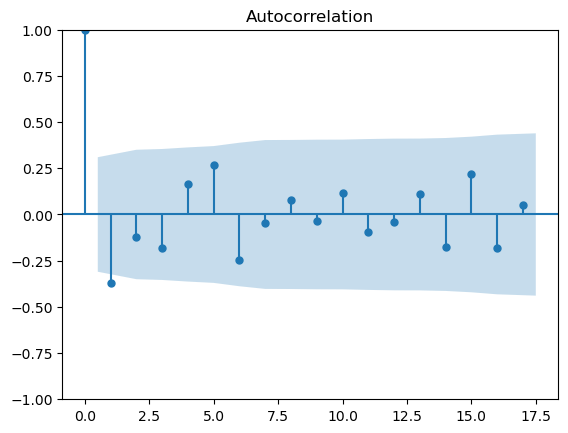

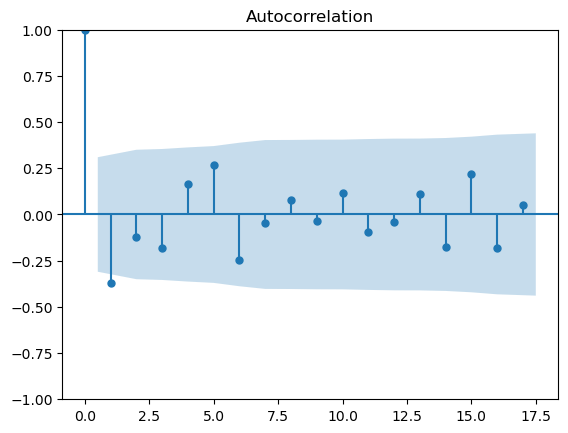

In [31]:
plot_acf(daily_data_diff2)

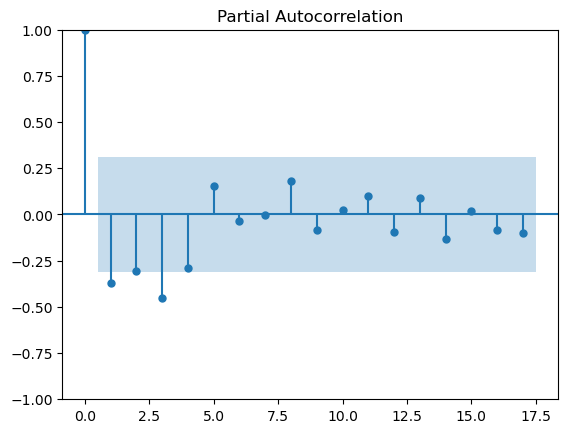

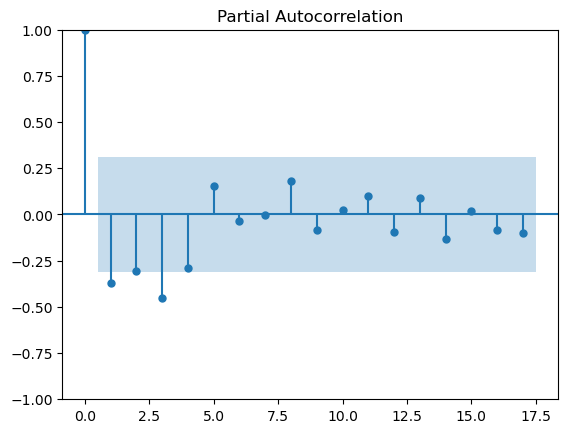

In [32]:
plot_pacf(daily_data_diff2, method='ywm')

# Identifying Best P & Q values

In [33]:
aicVals = []
for p in range(5):
    for q in range(5):
        aicVals.append([sm.ARIMA(daily_data_diff2, order = (p, 2, q) ).fit().aic, p, q])
        
        # (Weiss, 2023) Oct. 12th lecture

C:\Users\danie\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\danie\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\danie\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\danie\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\danie\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self.

In [34]:
aicVals.sort()

In [35]:
aicVals
    # p = 4, q = 2, d = 2 (twice differenced dataset)

[[554.290442841136, 4, 2],
 [555.5145181466921, 3, 3],
 [555.6275019683246, 4, 3],
 [563.1355157959997, 0, 3],
 [564.583481285143, 0, 4],
 [565.1208247856023, 1, 3],
 [565.1706418090141, 3, 2],
 [566.6474260949976, 4, 1],
 [566.8157850918413, 1, 4],
 [574.5025792427937, 2, 2],
 [575.9104651601334, 1, 2],
 [578.5270364621742, 0, 2],
 [579.1149157968199, 4, 4],
 [581.6057448238474, 2, 3],
 [583.1514577475924, 3, 4],
 [583.7412746780835, 2, 4],
 [584.9530964771217, 3, 1],
 [589.107522908349, 4, 0],
 [591.7897176210669, 2, 1],
 [594.5394273081181, 1, 1],
 [608.0506346871085, 3, 0],
 [608.0837972954405, 0, 1],
 [614.2334805420206, 2, 0],
 [621.1364257932516, 1, 0],
 [646.9953578234662, 0, 0]]

### Plotting Twice Differenciated Dataset

<Axes: title={'center': 'Daily Comment Volume'}, xlabel='created_date'>

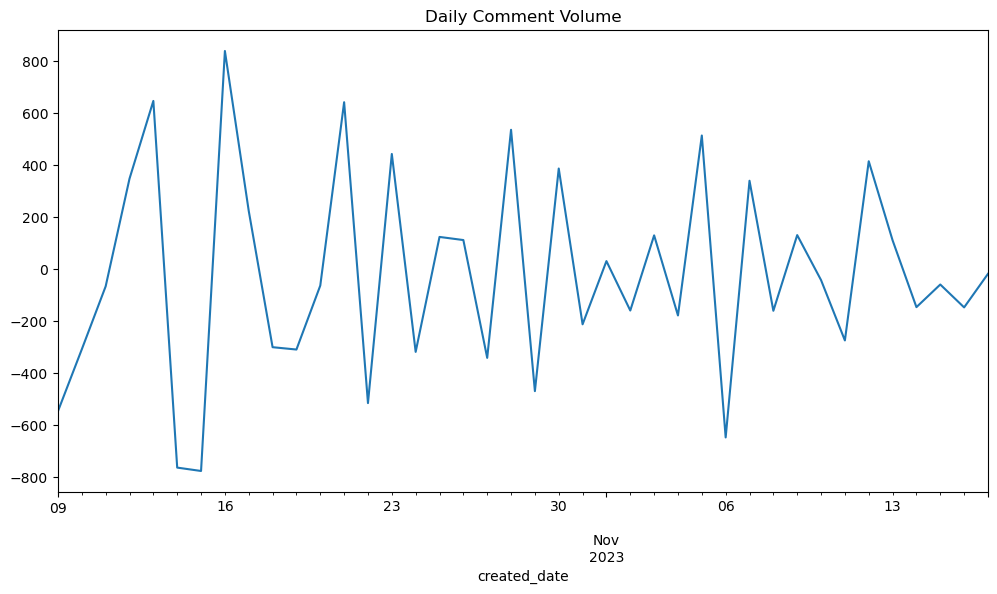

In [36]:
daily_data_diff2.plot(kind='line', figsize=(12, 6), title='Daily Comment Volume')

# Fitting ARIMA Model

In [37]:
    arima = ARIMA(daily_data_diff2, order=(4, 2, 2))
    arima_results = arima.fit()

C:\Users\danie\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\danie\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\danie\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\danie\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


based on the results from this ARIMA model, it's clear that we can reduce the q value from 2, down to 1. This was done because the ma.L2 = 0.9105 suggests it's not adding much value to the performance of the model.

In [38]:
print(arima_results.summary())
     # q could be reduced to 1
''' Despite ma.L2 not making much of a difference the AIC rose sharply when removed 
    Therefore, this is the best and final model.'''

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   40
Model:                 ARIMA(4, 2, 2)   Log Likelihood                -270.145
Date:                Thu, 02 May 2024   AIC                            554.290
Time:                        17:34:10   BIC                            565.754
Sample:                    10-09-2023   HQIC                           558.369
                         - 11-17-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.1050      0.136     -8.120      0.000      -1.372      -0.838
ar.L2         -1.1199      0.163     -6.884      0.000      -1.439      -0.801
ar.L3         -1.0512      0.150     -7.015      0.0

' Despite ma.L2 not making much of a difference the AIC rose sharply when removed \n    Therefore, this is the best and final model.'

In [39]:
arima2 = ARIMA(daily_data_diff2, order=(3, 2, 3))
arima2_results = arima2.fit()

C:\Users\danie\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\danie\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\danie\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\danie\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [40]:
print(arima2_results.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   40
Model:                 ARIMA(3, 2, 3)   Log Likelihood                -270.757
Date:                Thu, 02 May 2024   AIC                            555.515
Time:                        17:34:11   BIC                            566.978
Sample:                    10-09-2023   HQIC                           559.593
                         - 11-17-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3120      0.211     -1.477      0.140      -0.726       0.102
ar.L2         -0.5008      0.145     -3.444      0.001      -0.786      -0.216
ar.L3         -0.5095      0.232     -2.193      0.0

In [41]:
adjusted_ARIMA = ARIMA(daily_data_diff2, order=(4, 2, 1))
adjusted_arima_results = adjusted_ARIMA.fit()

C:\Users\danie\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\danie\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\danie\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


reducing q from 2 to 1, was expected to make a simplier but as effective model. However, as we can see that the AIC value jumped dramatically. Therefore, the first model fitted, with the values (p = 4, d = 2, and q = 2) performs best and will act as out final model. These values were discovered using the grid search technique implemented by Sam to find the best AIC values.

In [42]:
print(adjusted_arima_results.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   40
Model:                 ARIMA(4, 2, 1)   Log Likelihood                -277.324
Date:                Thu, 02 May 2024   AIC                            566.647
Time:                        17:34:11   BIC                            576.473
Sample:                    10-09-2023   HQIC                           570.143
                         - 11-17-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.3655      0.101    -13.491      0.000      -1.564      -1.167
ar.L2         -1.3599      0.151     -9.007      0.000      -1.656      -1.064
ar.L3         -1.2194      0.147     -8.311      0.0

# Forecasting

In [43]:
forecast = arima_results.forecast(steps = 10)
    # 10 steps as per brief

In [44]:
actual_diff2 = daily_data_diff2[-10:]
forecast_errors_diff2 = actual_diff2 - forecast

In [45]:
print("Forecast Errors for Twice-Differenced Data:", forecast_errors_diff2)

Forecast Errors for Twice-Differenced Data: 2023-11-08   NaN
2023-11-09   NaN
2023-11-10   NaN
2023-11-11   NaN
2023-11-12   NaN
2023-11-13   NaN
2023-11-14   NaN
2023-11-15   NaN
2023-11-16   NaN
2023-11-17   NaN
2023-11-18   NaN
2023-11-19   NaN
2023-11-20   NaN
2023-11-21   NaN
2023-11-22   NaN
2023-11-23   NaN
2023-11-24   NaN
2023-11-25   NaN
2023-11-26   NaN
2023-11-27   NaN
dtype: float64


#### Aligning forecast dates and daily_data_diff2 dates

The NaN values above suggest that there is a mismatch between the forecasted values and the actual differenced values. This is likely because the forecast dates exceed beyond the dates present in the daily_data_diff2 (the twice differenciated dataset)

To add align the dates, below I altered the indices of the forecasted series to match the end of the daily_data_diff2

In [46]:
aligned_index = actual_diff2.index[-10:]
forecast_aligned = pd.Series(forecast, index = aligned_index)

In [47]:
forecast_errors_aligned = actual_diff2[-10:] - forecast_aligned
print("Aligned Forecast Errors for Twice-Differenced Data:", forecast_errors_aligned)

Aligned Forecast Errors for Twice-Differenced Data: created_date
2023-11-08   NaN
2023-11-09   NaN
2023-11-10   NaN
2023-11-11   NaN
2023-11-12   NaN
2023-11-13   NaN
2023-11-14   NaN
2023-11-15   NaN
2023-11-16   NaN
2023-11-17   NaN
dtype: float64


### Visualising the Mismatch

As we can see aligning the dates above didn't work either so below I print the dates in order to visualise the mismatch.
We can see we're forecasting into the future.

In [48]:
print("Last dates in actual_diff2:")
print(actual_diff2.index[-10:])

Last dates in actual_diff2:
DatetimeIndex(['2023-11-08', '2023-11-09', '2023-11-10', '2023-11-11',
               '2023-11-12', '2023-11-13', '2023-11-14', '2023-11-15',
               '2023-11-16', '2023-11-17'],
              dtype='datetime64[ns]', name='created_date', freq=None)


In [49]:
print("Forecasted dates:")
print(forecast.index)

Forecasted dates:
DatetimeIndex(['2023-11-18', '2023-11-19', '2023-11-20', '2023-11-21',
               '2023-11-22', '2023-11-23', '2023-11-24', '2023-11-25',
               '2023-11-26', '2023-11-27'],
              dtype='datetime64[ns]', freq='D')


## Forecasting Last 10 Observations

Then the solution came to me - Firstly, I needed to ensure I wasn't making predictions into the future, but just the last 10 observations, and secondly, I needed to revert the differencing done. This is done below by going back to the original scale using cumulative sums and adding the last value of the undifferenced subset.

Once this was done I could visualise the actual vs forecast data including errors.

In [50]:
pred_10_diff2 = arima_results.predict(start=-10)

In [51]:
last_value_diff = daily_data_diff.iloc[-1]
pred_10_diff1 = pred_10_diff2.cumsum() + last_value_diff

In [52]:
last_original_value = daily_data.iloc[-1]
forecasted_original = pred_10_diff1.cumsum() + last_original_value

In [53]:
last_10_actual = daily_data[-10:]

In [54]:
forecast_errors = last_10_actual - forecasted_original

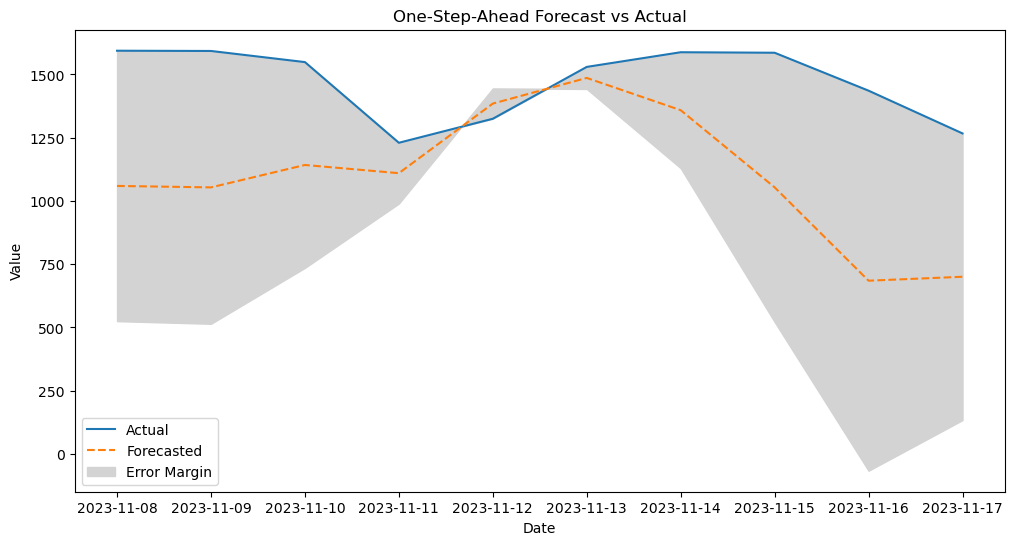

In [55]:
plt.figure(figsize=(12, 6))
plt.plot(daily_data.index[-10:], last_10_actual, label='Actual')
plt.plot(daily_data.index[-10:], forecasted_original, label='Forecasted', linestyle='--')
plt.fill_between(daily_data.index[-10:], forecasted_original - forecast_errors, forecasted_original + forecast_errors, color='lightgrey', label='Error Margin')
plt.legend()
plt.title('One-Step-Ahead Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Value')
plt.show()

### Forecasting Errors

In [56]:
forecast_errors = pd.DataFrame({'Actual': last_10_actual.values,
                              'Forecasted': forecasted_original.values,
                              'Error': forecast_errors.values}, index=last_10_actual.index)

In [57]:
forecast_errors

,Actual,Forecasted,Error
created_date,,,
2023-11-08,1594,1059.369184,534.630816
2023-11-09,1593,1053.652703,539.347297
2023-11-10,1549,1142.233271,406.766729
2023-11-11,1230,1109.829066,120.170934
2023-11-12,1325,1384.958811,-59.958811
2023-11-13,1530,1486.412489,43.587511
2023-11-14,1588,1358.858403,229.141597
2023-11-15,1586,1053.811233,532.188767
2023-11-16,1436,684.649750,751.350250


### In-Sample Forecasting

Initially, when executing this project I couldn't get the one-step-ahead forecasts to work. I expected this to be because my dataset needed to be differenced twice. Trying to align the dates didn't work. The forecasting was predicting dates that we did not have access to (as the dataset is so 'fresh' and up-to-date.

In order to answer part b of question one without spending too much time on it, I implemented an implemented a predict method for the last 10 observations. This involved predicting the last 10 day in the dataset, rather than future dates and then cross checked these with the actual dates in order to compute forecasting errors as per the brief. 

In [58]:
in_sample_forecast = arima_results.predict(start=daily_data_diff2.index[-10], end=daily_data_diff2.index[-1])

In [59]:
forecast_errors = daily_data_diff2[-10:] - in_sample_forecast
print("In-Sample Forecast Errors:", forecast_errors)

In-Sample Forecast Errors: created_date
2023-11-08   -122.369184
2023-11-09    -71.914336
2023-11-10   -137.297049
2023-11-11   -154.015226
2023-11-12    106.466049
2023-11-13    283.676067
2023-11-14     82.007764
2023-11-15    117.493084
2023-11-16    -83.885687
2023-11-17   -403.757148
dtype: float64


# Time Series Plot

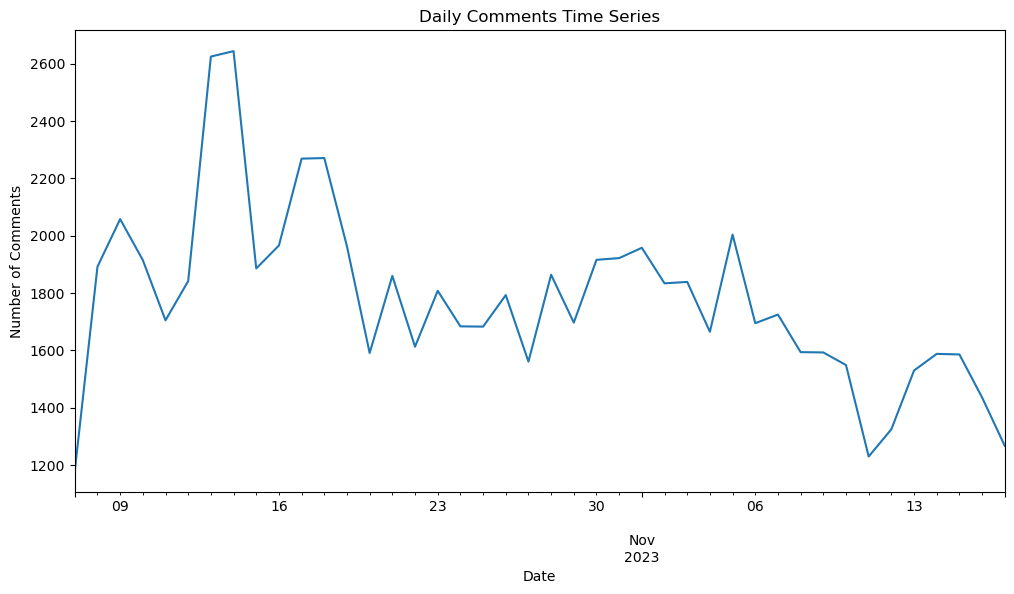

In [60]:
daily_data.plot(figsize=(12, 6), 
                title = 'Daily Comments Time Series', 
                xlabel='Date', 
                ylabel='Number of Comments');

# Sample & Partial Autocorrelation

## Sample Autocorrelation (ACF)

<Figure size 1200x600 with 0 Axes>

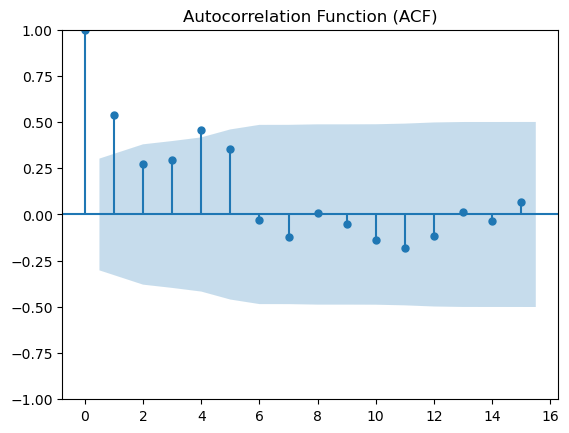

In [61]:
plt.figure(figsize=(12, 6))
plot_acf(daily_data, alpha=0.05, lags=15)
plt.title('Autocorrelation Function (ACF)')
plt.show()

## Partial Autocorrelation (PA)

<Figure size 1200x600 with 0 Axes>

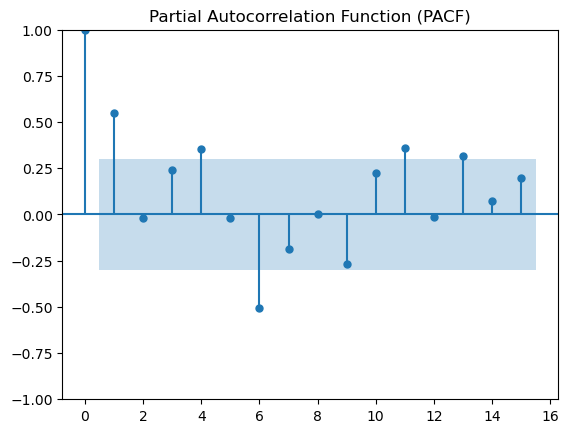

In [62]:
plt.figure(figsize=(12, 6))
plot_pacf(daily_data, alpha=0.05, lags=15)
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()

In [63]:
df.head()

,created_time,created_date
1073,2023-10-07 00:25:23+00:00,2023-10-07
1088,2023-10-07 00:59:10+00:00,2023-10-07
13,2023-10-07 04:16:47+00:00,2023-10-07
620,2023-10-07 04:23:35+00:00,2023-10-07
83,2023-10-07 04:39:14+00:00,2023-10-07


In [64]:
df.shape

(74625, 2)